In [1]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import numpy as np
import torch
import pandas as pd
import pickle

from sklearn.metrics import r2_score, mean_squared_error
# from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from scipy.spatial.distance import squareform, pdist
from joblib import Parallel, delayed

from sklearn.decomposition import PCA
import os, sys
root_path = root_path = os.path.realpath('../')
try:
    import ego_allo_rnns
except ModuleNotFoundError:
    sys.path.append(root_path)

from ego_allo_rnns.data.EgoVsAllo import make_testset_from_conditions, wrapper_make_testset_from_conditions

In [2]:
%matplotlib inline

In [3]:
results_dir = '../checkpoints/'
conditions = ["WCWC","SCWC","SCSC","WCSC"]
n_runs = 20

In [28]:
df, data_test = make_testset_from_conditions(sorting_mode=1)
df

,start_loc_id,target_loc_id,target_direction_id,start_loc_x,start_loc_y,target_loc_x,target_loc_y,target_loc_color,target_direction_color,start_loc_color,start_loc_label_x,start_loc_label_y,target_loc_label_x,target_loc_label_y,target_dir_label_x,target_dir_label_y
0,1,0,2,17,17,9,25,mediumseagreen,royalblue,palegreen,-8.0,-8.0,0.0,-16.0,8.0,-8.0
1,4,3,2,33,17,25,25,olive,royalblue,lightsalmon,-8.0,8.0,0.0,0.0,8.0,-8.0
2,3,2,2,25,25,17,33,green,royalblue,olive,0.0,0.0,8.0,-8.0,8.0,-8.0
3,6,5,2,41,25,33,33,sienna,royalblue,goldenrod,0.0,16.0,8.0,8.0,8.0,-8.0
4,1,3,4,17,17,25,25,olive,darkred,palegreen,-8.0,-8.0,0.0,0.0,8.0,8.0
5,4,6,4,33,17,41,25,goldenrod,darkred,lightsalmon,-8.0,8.0,0.0,16.0,8.0,8.0
6,0,2,4,9,25,17,33,green,darkred,mediumseagreen,0.0,-16.0,8.0,-8.0,8.0,8.0
7,3,5,4,25,25,33,33,sienna,darkred,olive,0.0,0.0,8.0,8.0,8.0,8.0
8,4,1,0,33,17,17,17,palegreen,dodgerblue,lightsalmon,-8.0,8.0,-8.0,-8.0,0.0,-16.0
9,3,0,0,25,25,9,25,mediumseagreen,dodgerblue,olive,0.0,0.0,0.0,-16.0,0.0,-16.0


## Preprocessing
First we need to create a test set of the 24 conditions we're interested in and feed it through each of the trained RNNs to obtain predictions.


In [270]:


device=torch.device("cuda" if torch.cuda.is_available() else "cpu")


testset_results = {}
for cond in conditions:
    df, data_test = make_testset_from_conditions(random_seed=123,input_type=cond[:2],output_type=cond[2:],sorting_mode=1,sortby=None)
    df.reset_index(inplace=True,drop=True)
    testset_results[cond] = {"predictions": [],
    "ground_truth" : [],
    "hidden_activity" : [],
    "rdms_startloc": [],
    "rdms_targetloc": [],
    "rdms_targetdir": []}
    for run_id in range(n_runs):
        # load model
        with open(f"{results_dir}run_{cond}_{run_id+1}/model.pkl", "rb") as f:
            rnn = pickle.load(f)
        
        predictions = []
        ground_truth = []
        hidden_activity = []
        rnn.to(device)
        for x,y in data_test:
            y_ = rnn.forward(x.reshape(1,11,1600).to(device))
            y_ = y_.to("cpu").detach().numpy()
            predictions.append(y_)
            ground_truth.append(y.to("cpu").detach().numpy())
            hidden_activity.append(rnn.ro.to("cpu").detach().numpy())
        # compute rdms per timepoint:
        rdms_startloc = []
        rdms_targetloc = []
        rdms_targetdir = []

        for t in range(11):
            
            respmat = np.asarray(hidden_activity).squeeze()[df.sort_values(["start_loc_id"],inplace=False).index.to_numpy(),t,:]            
            rdms_startloc.append(squareform(pdist(respmat,metric="correlation")))

            respmat = np.asarray(hidden_activity).squeeze()[df.sort_values(["target_loc_id"],inplace=False).index.to_numpy(),t,:]            
            rdms_targetloc.append(squareform(pdist(respmat,metric="correlation")))

            respmat = np.asarray(hidden_activity).squeeze()[df.sort_values(["target_direction_id"],inplace=False).index.to_numpy(),t,:]            
            rdms_targetdir.append(squareform(pdist(respmat,metric="correlation")))

        testset_results[cond]["ground_truth"].append(np.asarray(ground_truth))
        testset_results[cond]["predictions"].append(np.asarray(predictions).squeeze())
        testset_results[cond]["hidden_activity"].append(np.asarray(hidden_activity).squeeze())
        testset_results[cond]["rdms_startloc"].append(np.asarray(rdms_startloc))
        testset_results[cond]["rdms_targetloc"].append(np.asarray(rdms_targetloc))
        testset_results[cond]["rdms_targetdir"].append(np.asarray(rdms_targetdir))

        
    for k, v in testset_results[cond].items():
        testset_results[cond][k] = np.asarray(v)

## Performance evaluation

### Learning curves on training and validation data.
10k training samples, 2k validation samples.
Reported metrics: $MSE$ and $R^2$.


In [ ]:
# Learning Curves
lcurves = dict()
for i in conditions:
    lcurves[i] = {
        "losses": {"training": [], "validation": []},
        "r_squared": {"training": [], "validation": []},
    }

    for j in range(n_runs):        
        with open(f"{results_dir}run_{i}_{j+1}/training_results.pkl", "rb") as f:
            data = pickle.load(f)
        for k1 in data.keys():
            for k2 in data[k1].keys():
                lcurves[i][k1][k2].append(data[k1][k2])

# subplots: 4 rows (io conditions) by 4 columns (loss (train,val), r-squared(train,val))
f,axs = plt.subplots(4,4,figsize=(10,10),dpi=300)
axs = axs.flatten()

ax_id = 0

sem = lambda x,dim: np.std(x,dim)/np.sqrt(x.shape[dim])
for cond in conditions:
    for measure in lcurves[cond].keys():
        for ds in lcurves[cond][measure].keys():            
            y = np.asarray(lcurves[cond][measure][ds])            
            x = np.arange(y.shape[1])
            y_mu = np.mean(y,0)
            y_err = sem(y,0)
            axs[ax_id].plot(x,y_mu,'r-' if measure=="losses" else "b-")
            axs[ax_id].fill_between(x, y_mu-y_err,y_mu+y_err,color="grey",alpha=0.4)
            if measure == "losses":
                measure_label = "MSE"
            elif measure == "r_squared":
                measure_label = r"$R^2$"
            axs[ax_id].set(xlabel="epoch",ylabel=measure_label,title=f"{cond} \n {ds} set")
            ax_id +=1
plt.tight_layout()
            


### Test set performance.  
Accuracy of RNN's prediction on test set trials that are identical to those reported in the paper

In [ ]:
# test set performance
f, axs = plt.subplots(2,2,figsize=(14,8),dpi=300)
axs = axs.flatten()
labels = ["target_loc_color","target_loc_color","target_direction_color","target_direction_color"]

for ax,cond,label in zip(axs,conditions,labels):
    
    target_colors = df[label]
    coords_gt = testset_results[cond]["ground_truth"][0,:,[1,0]]
    ax.scatter(*coords_gt,s=1000,marker='o',c=target_colors.to_numpy(),edgecolor='k',alpha=0.2)
    for run_id in range(n_runs):    
        coords_pred = testset_results[cond]["predictions"][run_id,:,[1,0]]
        ax.scatter(*coords_pred,marker="*",c=target_colors.to_numpy())

    r2 = r2_score(testset_results[cond]["ground_truth"].reshape(n_runs*24,2),testset_results[cond]["predictions"].reshape(n_runs*24,2),multioutput="uniform_average")
    mse = mean_squared_error(testset_results[cond]["ground_truth"].reshape(n_runs*24,2),testset_results[cond]["predictions"].reshape(n_runs*24,2),multioutput="uniform_average")
    ax.set_axis_off()
    ax.set_title(cond+"\n"+r"$R^2$="+f"{r2:.2f}, MSE={mse:.2f}")
    

## Recurrent Unit activity

### PCA on activity of recurrent units

In [ ]:
# f, axs = plt.subplots(2,2,figsize=(14,8),dpi=300)
# axs = axs.flatten()
# labels = ["target_loc_color","target_loc_color","target_direction_color","target_direction_color"]

# for ax,cond,label in zip(axs,conditions,labels):
    
#     target_colors = df[label]
#     coords_gt = testset_results[cond]["ground_truth"][0,:,[1,0]]
#     # ax.scatter(*coords_gt,s=1000,marker='o',c=target_colors.to_numpy(),edgecolor='k',alpha=0.2)
#     for run_id in range(2,3):    
#         y_hidden = testset_results[cond]["hidden_activity"][run_id,:,-1,:].squeeze()
#         # apply pca
#         pca = PCA(n_components=2)
#         y_reduced = pca.fit_transform(y_hidden).T
#         ax.scatter(*y_reduced,marker="*",c=target_colors.to_numpy())

    
#     ax.set_axis_off()
#     ax.set_title(cond+"\n"+"hidden layer, first two PCs, last timestep")

In [ ]:
# # PCA across runs, for the lolz
# f, axs = plt.subplots(2,2,figsize=(14,8),dpi=300)
# axs = axs.flatten()
# labels = ["target_loc_color","target_loc_color","target_direction_color","target_direction_color"]

# for ax,cond,label in zip(axs,conditions,labels):
    
#     target_colors = df[label]
#     coords_gt = testset_results[cond]["ground_truth"][0,:,[1,0]]
#     # ax.scatter(*coords_gt,s=1000,marker='o',c=target_colors.to_numpy(),edgecolor='k',alpha=0.2)
    
#     y_hidden = testset_results[cond]["hidden_activity"][:,:,-1,:].squeeze()
#     y_swapped = np.swapaxes(y_hidden,1,0)
#     y_swapped = y_swapped.reshape(24,20*100)
#     # apply pca
#     pca = PCA(n_components=2)
#     y_reduced = pca.fit_transform(y_swapped).T
#     ax.scatter(*y_reduced[:2,:],marker="*",c=target_colors.to_numpy())

    
#     ax.set_axis_off()
#     ax.set_title(cond+"\n"+"hidden layer, first two PCs, last timestep")

In [ ]:
# now look at the data across time

labels = ["start_loc_color","target_loc_color","target_direction_color"]

for cond in conditions:    
    y_reduced = []
    for t in range(11):
        y_hidden = testset_results[cond]["hidden_activity"][:,:,t,:].squeeze()
        y_swapped = np.swapaxes(y_hidden,1,0)
        y_swapped = y_swapped.reshape(24,20*100)
        pca = PCA(n_components=5)
        y_reduced.append(pca.fit_transform(y_swapped).T)
    y_reduced = np.asarray(y_reduced)
    print(y_reduced.shape)
    
    f, axs = plt.subplots(3,5,figsize=(15,8),dpi=300)
    
    for xi, label in enumerate(labels):
        for yi in range(y_reduced.shape[1]):
            for li in range(y_reduced.shape[-1]):
                axs[xi,yi].plot(y_reduced[:,yi,li],color=df[label][li],linewidth=1)
            axs[xi,yi].set(xlabel="frame",ylabel=f"{label} \n a.u.",title=f"PC {yi+1}")
    
    plt.suptitle(cond)
    plt.tight_layout()

In [ ]:
%matplotlib qt
from mpl_toolkits import mplot3d
fig = plt.figure()
ax = plt.axes(projection='3d')
for li in range(y_reduced.shape[-1]):
    ax.plot(*y_reduced[:,:3,li].T,color=df[label][li],linewidth=1,marker='o')

In [ ]:
# now look at the data across time

labels = ["start_loc_color","target_loc_color","target_direction_color"]

for cond in conditions:    
    y_reduced = []
    for t in range(11):
        y_hidden = testset_results[cond]["hidden_activity"][:,:,t,:].squeeze()
        y_swapped = np.swapaxes(y_hidden,1,0)
        y_swapped = y_swapped.reshape(24,20*100)
        pca = PCA(n_components=3)
        y_reduced.append(pca.fit_transform(y_swapped).T)
    y_reduced = np.asarray(y_reduced)
    print(y_reduced.shape)
    
    f= plt.figure(figsize=(15,8),dpi=300)
    
    for xi, label in enumerate(labels):
        ax = f.add_subplot(1,3,xi+1, projection="3d")
        for li in range(y_reduced.shape[-1]):
            ax.plot(*y_reduced[:,:3,li].T,color=df[label][li],linewidth=1,marker='o')
           
    
    plt.suptitle(cond)
    plt.tight_layout()

### Decoding of start & target location or target direction
Given recurrent unit activity $h_t \in \mathbb{R}^{n,m}$ with $n$ trials and $m$ units, try to decode the (a) location of the start poke, (b) location of the target poke or (c) direction to the target poke at each time point $t$.
Evaluate performance on held-out data, with $R^2$ or negative MSE as metric in cross-validation.  


In [9]:
n_chunks = 10


device=torch.device("cuda" if torch.cuda.is_available() else "cpu")


mvpa_patterns = {}
for cond in conditions:
    df, data_test = wrapper_make_testset_from_conditions(input_type=cond[:2],output_type=cond[2:],n_chunks=n_chunks)
    mvpa_patterns[cond] = {
    "hidden_activity" : [],
    "df":df}
    for run_id in range(n_runs):
        # load model
        with open(f"{results_dir}run_{cond}_{run_id+1}/model.pkl", "rb") as f:
            rnn = pickle.load(f)
        
        
        hidden_activity = []
        rnn.to(device)
        for x,y in data_test:
            _ = rnn.forward(x.reshape(1,11,1600).to(device))
                        
            hidden_activity.append(rnn.ro.to("cpu").detach().numpy())
        
        mvpa_patterns[cond]["hidden_activity"].append(np.asarray(hidden_activity).squeeze())
    
    mvpa_patterns[cond]["hidden_activity"] = np.asarray(mvpa_patterns[cond]["hidden_activity"])

In [179]:
# all the for loops ....
def fit_linear_model(X, y):
    regr = make_pipeline(StandardScaler(), LinearRegression())
    pca = PCA(n_components=4)
    X = pca.fit_transform(X)
    return cross_val_score(regr, X, y, scoring=score, n_jobs=1, cv=10).mean()


features_to_decode = ["start_loc_label_", "target_loc_label_", "target_dir_label_"]
i, j = map(lambda x: x.flatten(), np.meshgrid(range(n_runs), range(11)))

score = "r2"  
cval_scores = {}
for cond in conditions:
    cval_scores[cond] = {f: [] for f in features_to_decode}
    for f in features_to_decode:
        y = mvpa_patterns[cond]["df"][[f + "x", f + "y"]].to_numpy()
        cval_scores[cond][f] = Parallel(n_jobs=-1,verbose=3)(
            delayed(fit_linear_model)(
                mvpa_patterns[cond]["hidden_activity"][xi, :, xj, :], y
            )
            for xi, xj in zip(i, j)
        )
        cval_scores[cond][f] = np.asarray(cval_scores[cond][f]).reshape((11,n_runs)).T


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 220 out of 220 | elapsed:    1.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 197 out of 220 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 220 out of 220 | elapsed:    1.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 220 out of 220 | elapsed:    0.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 220 out of 220 | elapsed:    1.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[P

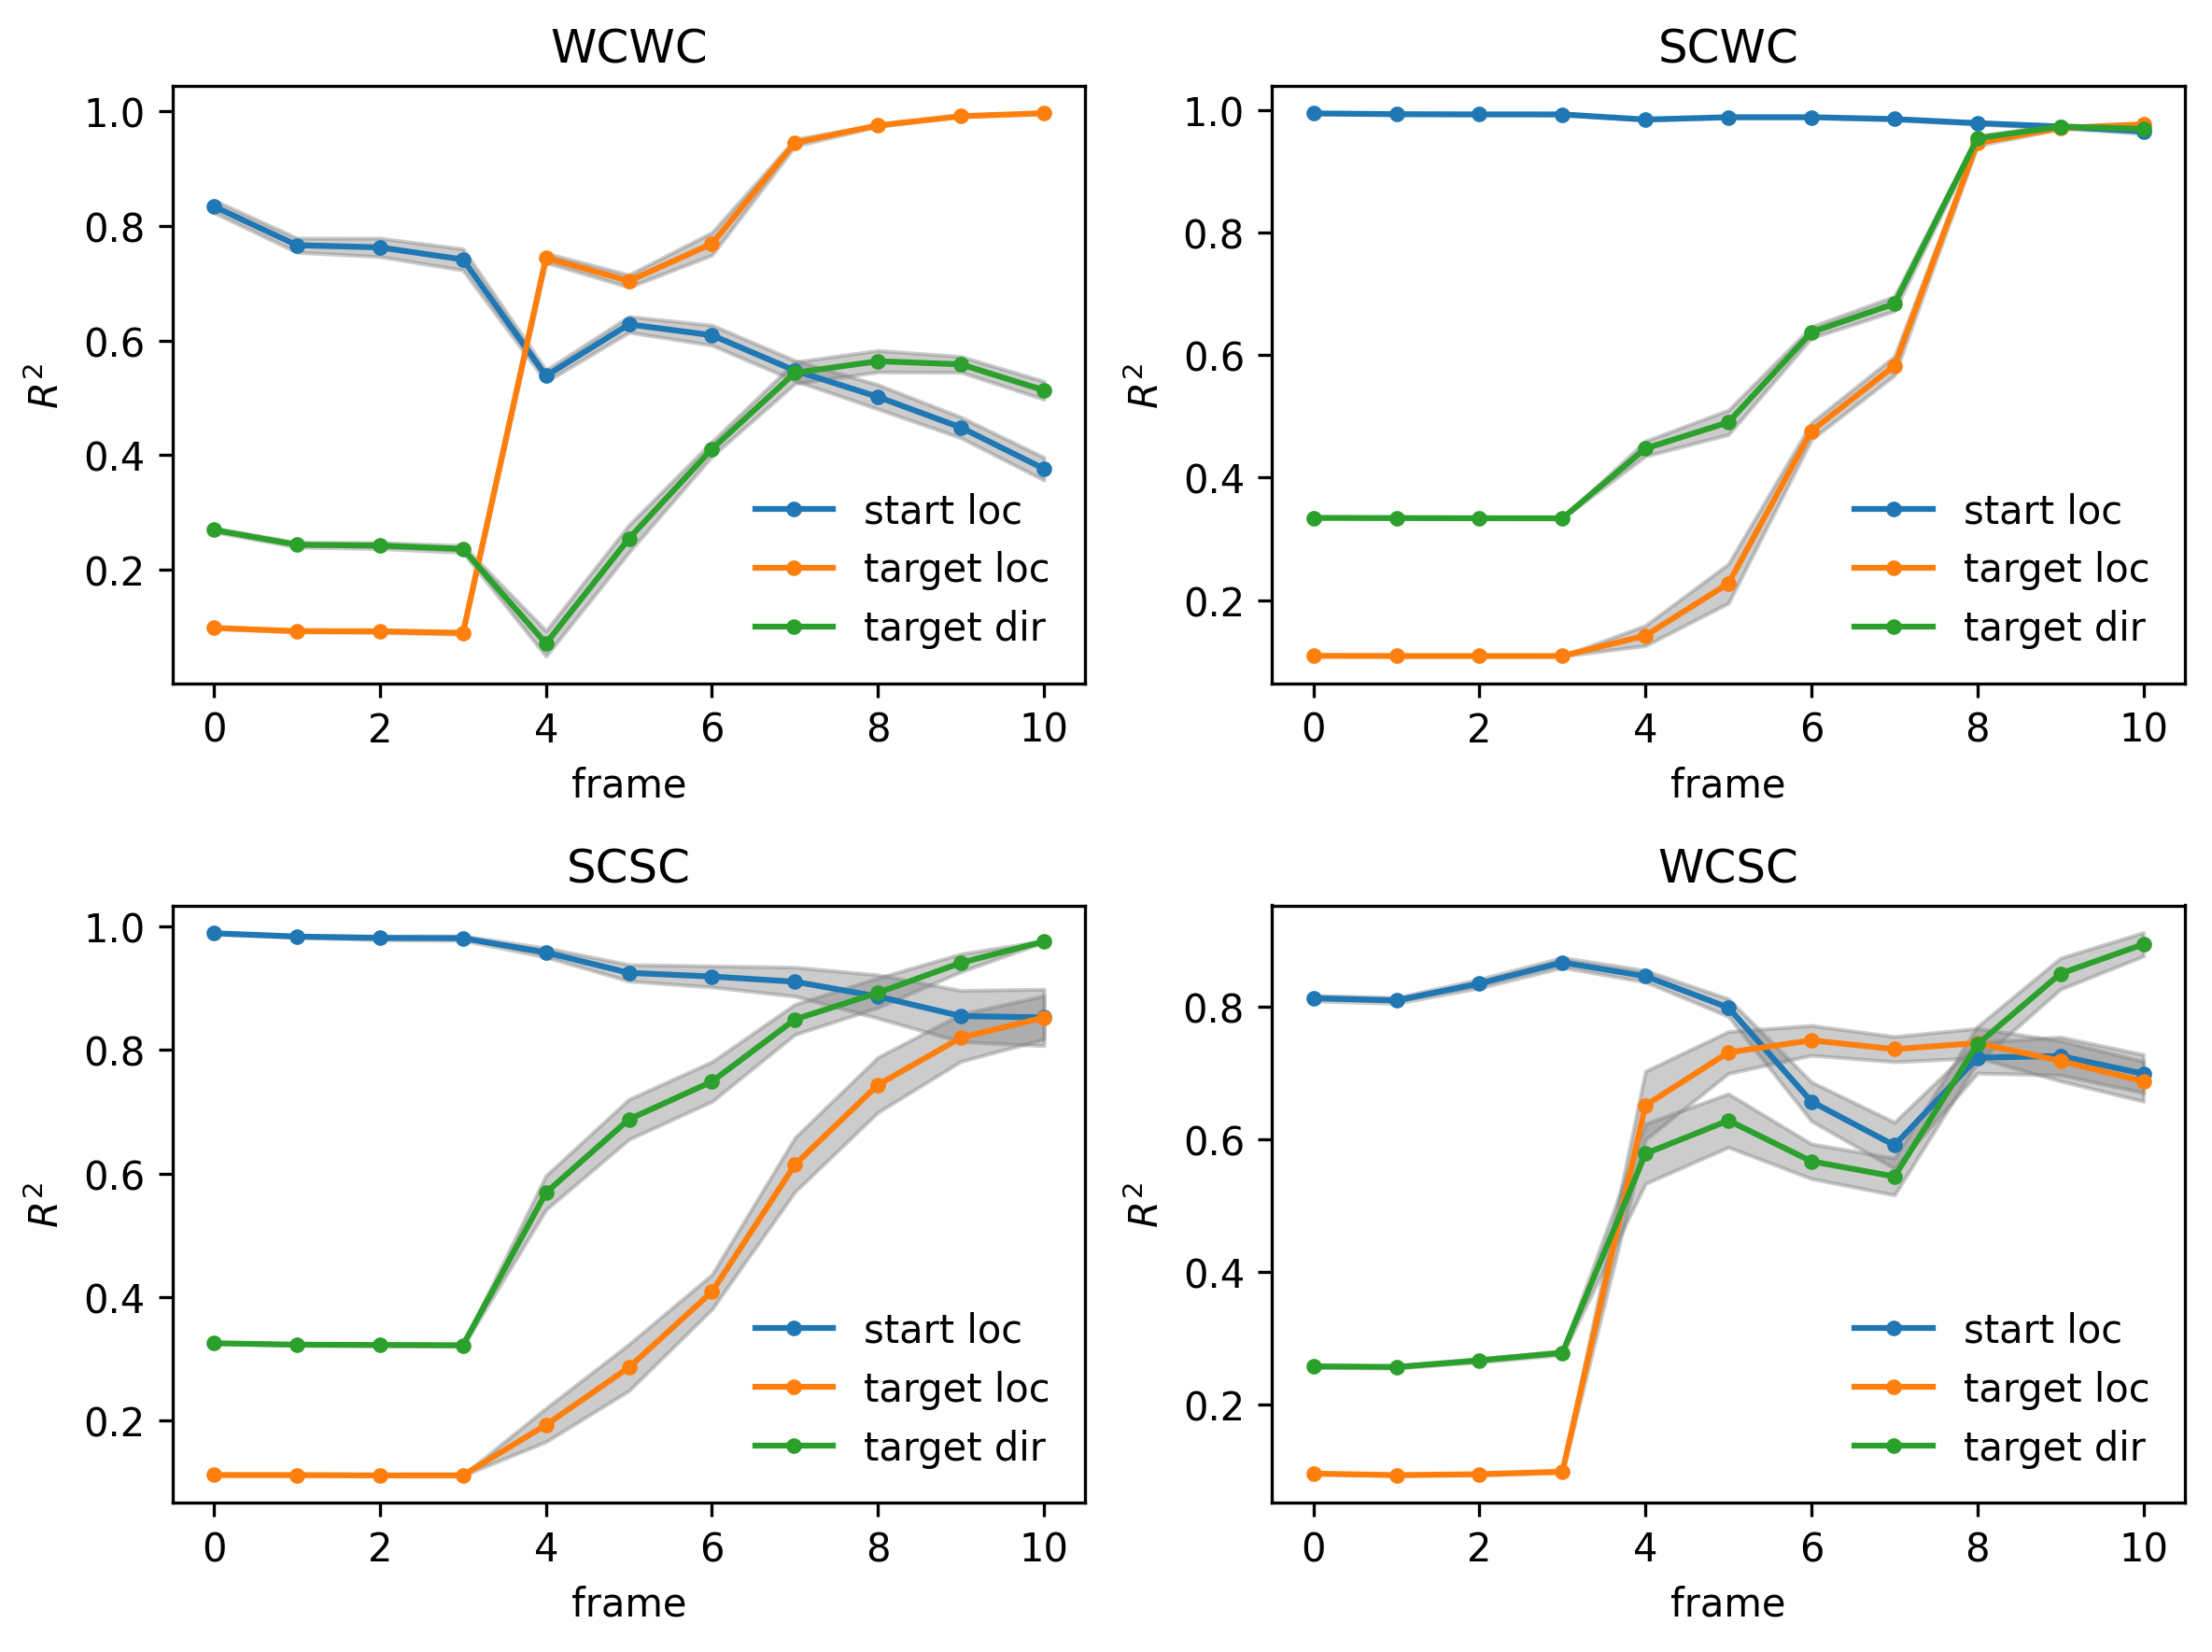

In [180]:
f, axs = plt.subplots(2,2,figsize=(8,6),dpi=300)
axs = axs.flatten()
sem = lambda x,dim: np.std(x,dim)/np.sqrt(x.shape[dim])
for cond, ax in zip(conditions,axs):
    ls = []
    for k,v in cval_scores[cond].items():
        y_mu = v.mean(0)
        y_err = sem(v,0) 
        l = ax.plot(np.arange(len(y_mu)),y_mu,'-',marker='.')
        ls.append(l[0])
        ax.fill_between(np.arange(len(y_mu)), y_mu-y_err,y_mu+y_err,color="grey",alpha=0.4)
    ax.legend(ls, [" ".join(f.split("_")[:2]) for f in features_to_decode],frameon=False)
    
    ax.set(xlabel="frame",ylabel=r"$R^2$",title=cond)
plt.tight_layout()

### Representational Similarity Analysis

1. create model RDMs for start location, target location and target direction
2. compute empirical RDMs based on RNN patterns 
3. regress 2 against 1 at each time point, log betas 
4. plot time series of beta coefficients 

- do above on first 4 PCs only
- apply same pipeline to neural data (for the different epochs)
- perform cross-temporal rank correlation between nnet and brain RDMs (best alignment with WCSC?)

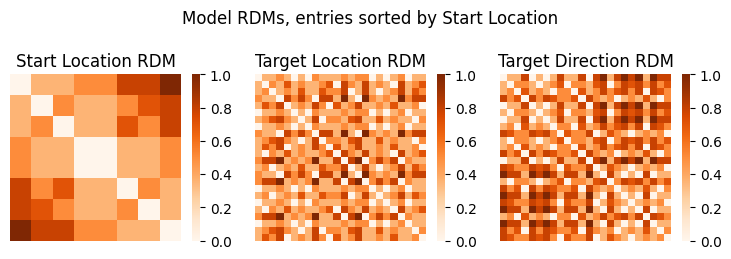

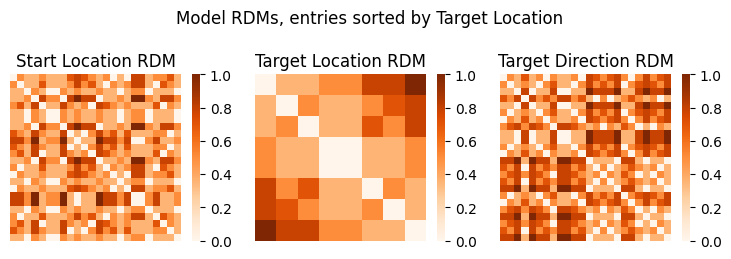

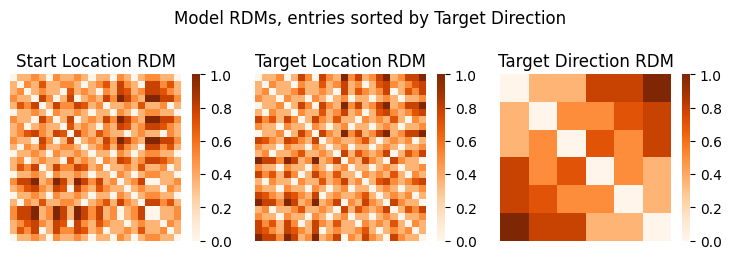

In [260]:
df, data_test = make_testset_from_conditions(sorting_mode=1,sortby=None)

df.sort_values("start_loc_id",inplace=True)
rdm_startloc = squareform(pdist(df[["start_loc_label_x","start_loc_label_y"]]))
rdm_targetloc = squareform(pdist(df[["target_loc_label_x","target_loc_label_y"]]))
rdm_targetdir = squareform(pdist(df[["target_dir_label_x","target_dir_label_y"]]))
rdm_startloc/=np.max(rdm_startloc)
rdm_targetloc/=np.max(rdm_targetloc)
rdm_targetdir/=np.max(rdm_targetdir)
plt.figure(figsize=(7.5,2.6))
plt.set_cmap("Blues")
plt.subplot(1,3,1)
sns.heatmap(rdm_startloc,cbar=True,xticklabels=False,yticklabels=False,cmap="Oranges")
plt.title("Start Location RDM")
plt.subplot(1,3,2)
sns.heatmap(rdm_targetloc,cbar=True,xticklabels=False,yticklabels=False,cmap="Oranges")
plt.title("Target Location RDM")
plt.subplot(1,3,3)
sns.heatmap(rdm_targetdir,cbar=True,xticklabels=False,yticklabels=False,cmap="Oranges")
plt.title("Target Direction RDM")
plt.suptitle("Model RDMs, entries sorted by Start Location")
plt.tight_layout()

df.sort_values("target_loc_id",inplace=True)
rdm_startloc = squareform(pdist(df[["start_loc_label_x","start_loc_label_y"]]))
rdm_targetloc = squareform(pdist(df[["target_loc_label_x","target_loc_label_y"]]))
rdm_targetdir = squareform(pdist(df[["target_dir_label_x","target_dir_label_y"]]))
rdm_startloc/=np.max(rdm_startloc)
rdm_targetloc/=np.max(rdm_targetloc)
rdm_targetdir/=np.max(rdm_targetdir)
plt.figure(figsize=(7.5,2.6))
plt.set_cmap("Blues")
plt.subplot(1,3,1)
sns.heatmap(rdm_startloc,cbar=True,xticklabels=False,yticklabels=False,cmap="Oranges")
plt.title("Start Location RDM")
plt.subplot(1,3,2)
sns.heatmap(rdm_targetloc,cbar=True,xticklabels=False,yticklabels=False,cmap="Oranges")
plt.title("Target Location RDM")
plt.subplot(1,3,3)
sns.heatmap(rdm_targetdir,cbar=True,xticklabels=False,yticklabels=False,cmap="Oranges")
plt.title("Target Direction RDM")
plt.suptitle("Model RDMs, entries sorted by Target Location")
plt.tight_layout()

df.sort_values("target_direction_id",inplace=True)
rdm_startloc = squareform(pdist(df[["start_loc_label_x","start_loc_label_y"]]))
rdm_targetloc = squareform(pdist(df[["target_loc_label_x","target_loc_label_y"]]))
rdm_targetdir = squareform(pdist(df[["target_dir_label_x","target_dir_label_y"]]))
rdm_startloc/=np.max(rdm_startloc)
rdm_targetloc/=np.max(rdm_targetloc)
rdm_targetdir/=np.max(rdm_targetdir)
plt.figure(figsize=(7.5,2.6))
plt.set_cmap("Blues")
plt.subplot(1,3,1)
mask = np.triu(np.ones_like(rdm_startloc),k=1)
sns.heatmap(rdm_startloc,cbar=True,xticklabels=False,yticklabels=False,cmap="Oranges")
plt.title("Start Location RDM")
plt.subplot(1,3,2)
sns.heatmap(rdm_targetloc,cbar=True,xticklabels=False,yticklabels=False,cmap="Oranges")
plt.title("Target Location RDM")
plt.subplot(1,3,3)
sns.heatmap(rdm_targetdir,cbar=True,xticklabels=False,yticklabels=False,cmap="Oranges")
plt.title("Target Direction RDM")
plt.suptitle("Model RDMs, entries sorted by Target Direction")
plt.tight_layout()


Text(0.5, 1.0, 'Correlation between model RDMs')

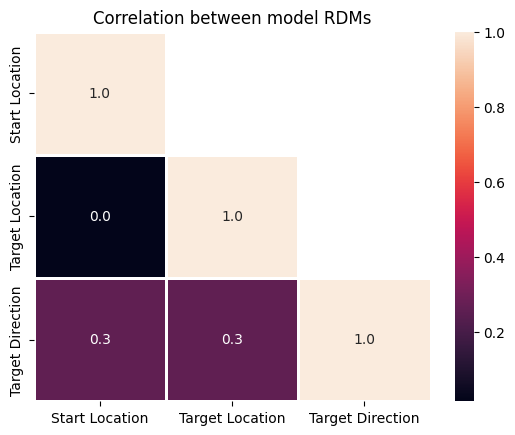

In [57]:
corr = np.corrcoef([rdm_startloc.flatten(),rdm_targetloc.flatten(),rdm_targetdir.flatten()])
mask = np.triu(np.ones_like(corr),k=1)
sns.heatmap(corr,annot=True, fmt=".1f", linewidth=1,xticklabels=["Start Location","Target Location","Target Direction"],yticklabels=["Start Location","Target Location","Target Direction"],mask=mask)
plt.title("Correlation between model RDMs")

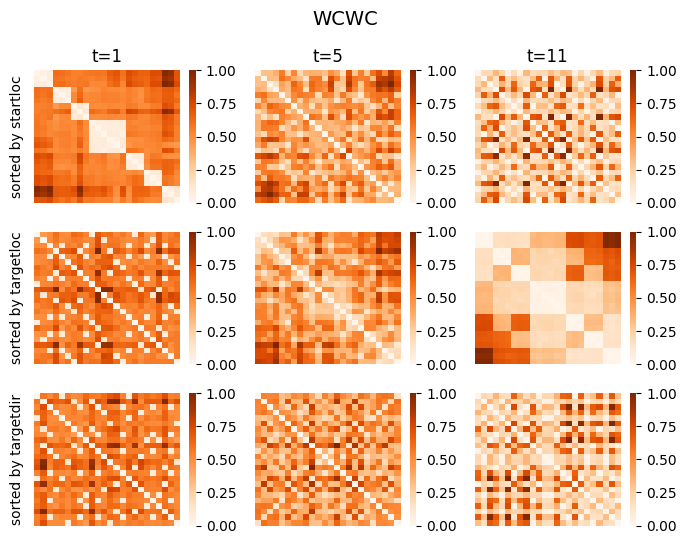

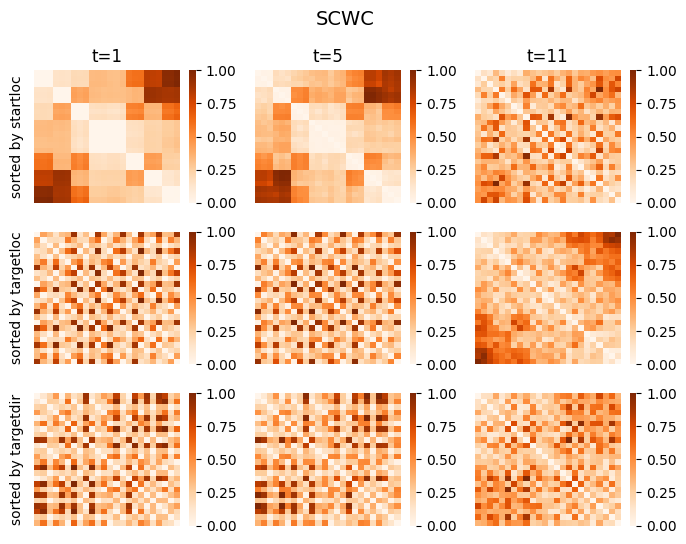

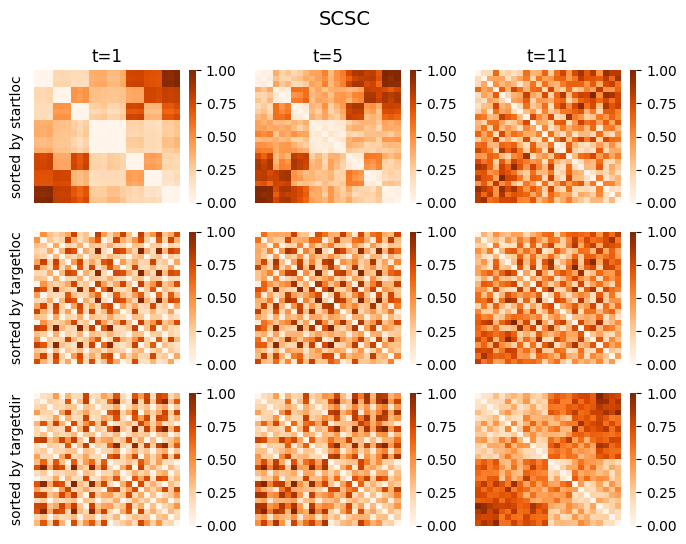

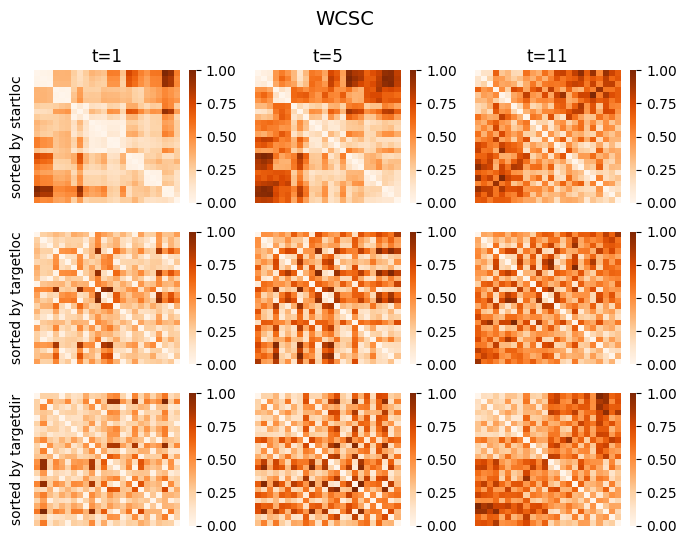

In [271]:
# for each condition, show 3x3 grid (sortedby x t=1, t=5, t=11)
ts = [0,4,10]
for cond in testset_results.keys():
    f,axs = plt.subplots(3,3,figsize=(7,5.5))
    for i,s in enumerate([k for k in testset_results[cond].keys() if "rdms" in k]):
        for j,t in enumerate(ts):            
            rdm = testset_results[cond][s].mean(0)[t,:,:]
            rdm /= np.max(rdm)
            show_cbar =True# True if j==2 else False
            sns.heatmap(rdm,cbar=show_cbar,xticklabels=False,yticklabels=False,cmap="Oranges",ax=axs[i, j])
            if i==0:
                axs[i,j].set_title(f"t={t+1}")
            if j==0:
                axs[i,j].set_ylabel(f"sorted by {s.split('_')[1]}")
            # axs[i,j].set_box_aspect(1)
            # axs[i,j].set_aspect('equal',"box")
    plt.suptitle(cond,fontsize=14)
    plt.tight_layout()

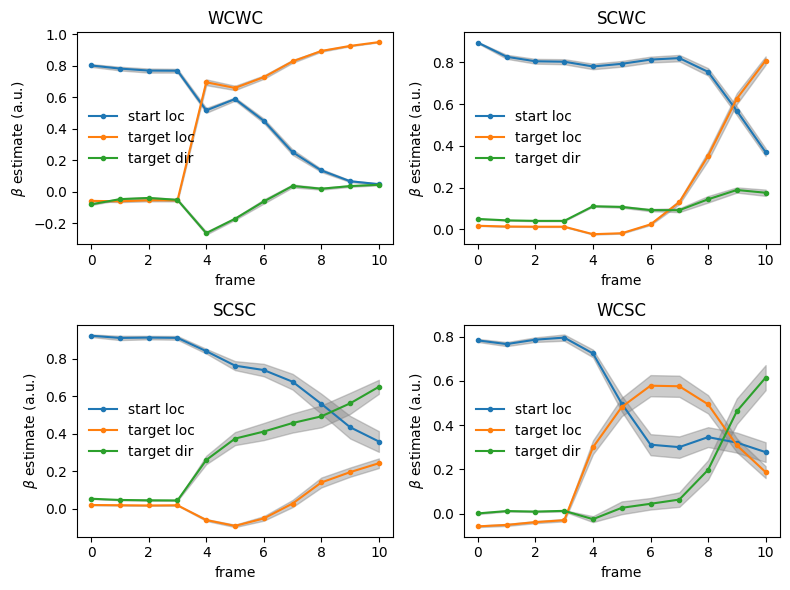

In [295]:
# now perform regressions
from scipy.stats import zscore 
regr = LinearRegression()
conditions = ["WCWC","SCWC","SCSC","WCSC"]
model_names = ["start loc", "target loc", "target dir"]
df, data_test = make_testset_from_conditions(random_seed=123,input_type=cond[:2],output_type=cond[2:],sorting_mode=1,sortby=None)
df.reset_index(inplace=True,drop=True)
df.sort_values("start_loc_id",inplace=True)
model_rdms = []
model_rdms.append(squareform(pdist(df[["start_loc_label_x","start_loc_label_y"]])))
model_rdms.append(squareform(pdist(df[["target_loc_label_x","target_loc_label_y"]])))
model_rdms.append(squareform(pdist(df[["target_dir_label_x","target_dir_label_y"]])))
model_rdms = [rdm/np.max(rdm) for rdm in model_rdms]
design_matrix = np.asarray([zscore(rdm[np.tril_indices(24,k=-1)].flatten()) for rdm in model_rdms]).T
betas = {}
for cond in conditions:
    betas[cond] = np.empty((20,11,len(model_names)))
    for ir in range(20):
        for it in range(11):
            yrdm = testset_results[cond]["rdms_startloc"][ir,it,:,:]
            yrdm = zscore(yrdm[np.tril_indices(24,k=-1)].flatten()).reshape(-1,1)
            
            regr.fit(design_matrix,yrdm)
            betas[cond][ir,it,:] = regr.coef_.flatten()


f, axs = plt.subplots(2,2,figsize=(8,6))
axs = axs.flatten()
sem = lambda x,dim: np.std(x,dim)/np.sqrt(x.shape[dim])
for cond, ax in zip(conditions,axs):
    ls = []
    for i in range(len(model_names)):
        v = betas[cond][:,:,i]
        y_mu = v.mean(0)
        y_err = sem(v,0) 
        l = ax.plot(np.arange(len(y_mu)),y_mu,'-',marker='.')
        ls.append(l[0])
        ax.fill_between(np.arange(len(y_mu)), y_mu-y_err,y_mu+y_err,color="grey",alpha=0.4)
    ax.legend(ls, model_names,frameon=False)
    
    ax.set(xlabel="frame",ylabel=r"$\beta$ estimate (a.u.)",title=cond)
plt.tight_layout()

### "Ablation" study

Does the network rely on the "bounding box" to infer locations in the SC* conditions? Let's test by feeding in images without bounding boxes

In [322]:
bbox_intensity = 0.0



device=torch.device("cuda" if torch.cuda.is_available() else "cpu")


testset_results = {}
for cond in conditions:
    df, data_test = make_testset_from_conditions(random_seed=123,input_type=cond[:2],output_type=cond[2:],sorting_mode=1,sortby=None,bbox_intensity=bbox_intensity)
    df.reset_index(inplace=True,drop=True)
    testset_results[cond] = {"predictions": [],
    "ground_truth" : [],
    "hidden_activity" : [],
    "rdms_startloc": [],
    "rdms_targetloc": [],
    "rdms_targetdir": []}
    for run_id in range(n_runs):
        # load model
        with open(f"{results_dir}run_{cond}_{run_id+1}/model.pkl", "rb") as f:
            rnn = pickle.load(f)
        
        predictions = []
        ground_truth = []
        hidden_activity = []
        rnn.to(device)
        for x,y in data_test:
            y_ = rnn.forward(x.reshape(1,11,1600).to(device))
            y_ = y_.to("cpu").detach().numpy()
            predictions.append(y_)
            ground_truth.append(y.to("cpu").detach().numpy())
            hidden_activity.append(rnn.ro.to("cpu").detach().numpy())
        # compute rdms per timepoint:
        rdms_startloc = []
        rdms_targetloc = []
        rdms_targetdir = []

        for t in range(11):
            
            respmat = np.asarray(hidden_activity).squeeze()[df.sort_values(["start_loc_id"],inplace=False).index.to_numpy(),t,:]            
            rdms_startloc.append(squareform(pdist(respmat,metric="correlation")))

            respmat = np.asarray(hidden_activity).squeeze()[df.sort_values(["target_loc_id"],inplace=False).index.to_numpy(),t,:]            
            rdms_targetloc.append(squareform(pdist(respmat,metric="correlation")))

            respmat = np.asarray(hidden_activity).squeeze()[df.sort_values(["target_direction_id"],inplace=False).index.to_numpy(),t,:]            
            rdms_targetdir.append(squareform(pdist(respmat,metric="correlation")))

        testset_results[cond]["ground_truth"].append(np.asarray(ground_truth))
        testset_results[cond]["predictions"].append(np.asarray(predictions).squeeze())
        testset_results[cond]["hidden_activity"].append(np.asarray(hidden_activity).squeeze())
        testset_results[cond]["rdms_startloc"].append(np.asarray(rdms_startloc))
        testset_results[cond]["rdms_targetloc"].append(np.asarray(rdms_targetloc))
        testset_results[cond]["rdms_targetdir"].append(np.asarray(rdms_targetdir))

        
    for k, v in testset_results[cond].items():
        testset_results[cond][k] = np.asarray(v)



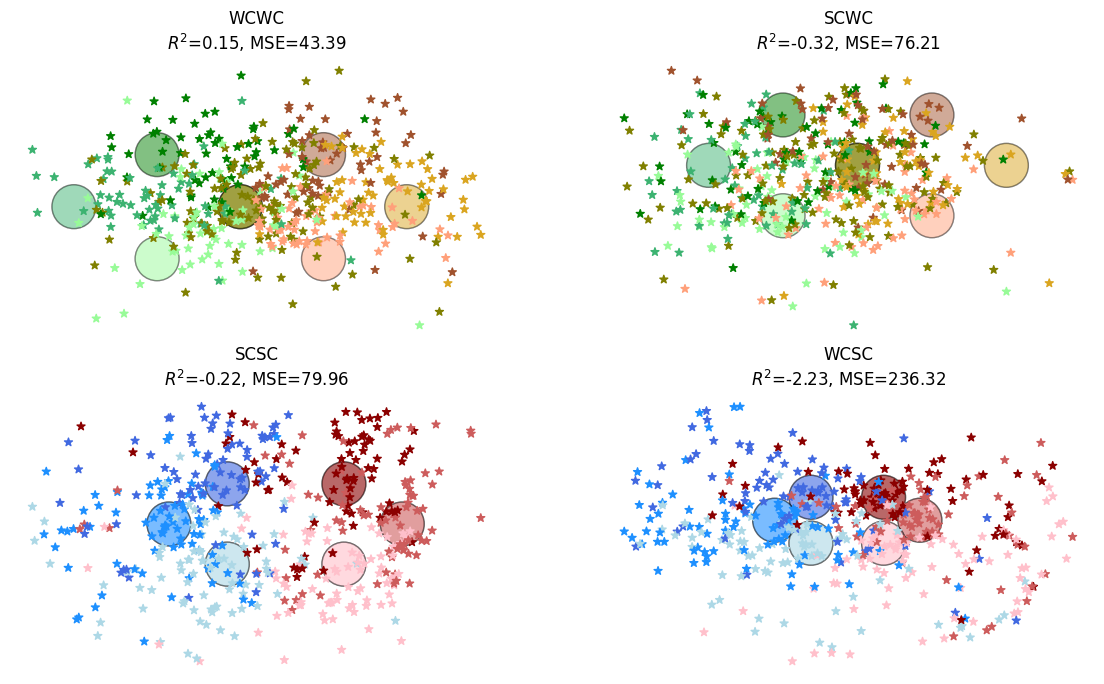

In [323]:
# test set performance
f, axs = plt.subplots(2,2,figsize=(14,8))
axs = axs.flatten()
labels = ["target_loc_color","target_loc_color","target_direction_color","target_direction_color"]

for ax,cond,label in zip(axs,conditions,labels):
    
    target_colors = df[label]
    coords_gt = testset_results[cond]["ground_truth"][0,:,[1,0]]
    ax.scatter(*coords_gt,s=1000,marker='o',c=target_colors.to_numpy(),edgecolor='k',alpha=0.2)
    for run_id in range(n_runs):    
        coords_pred = testset_results[cond]["predictions"][run_id,:,[1,0]]
        ax.scatter(*coords_pred,marker="*",c=target_colors.to_numpy())

    r2 = r2_score(testset_results[cond]["ground_truth"].reshape(n_runs*24,2),testset_results[cond]["predictions"].reshape(n_runs*24,2),multioutput="uniform_average")
    mse = mean_squared_error(testset_results[cond]["ground_truth"].reshape(n_runs*24,2),testset_results[cond]["predictions"].reshape(n_runs*24,2),multioutput="uniform_average")
    ax.set_axis_off()
    ax.set_title(cond+"\n"+r"$R^2$="+f"{r2:.2f}, MSE={mse:.2f}")
    

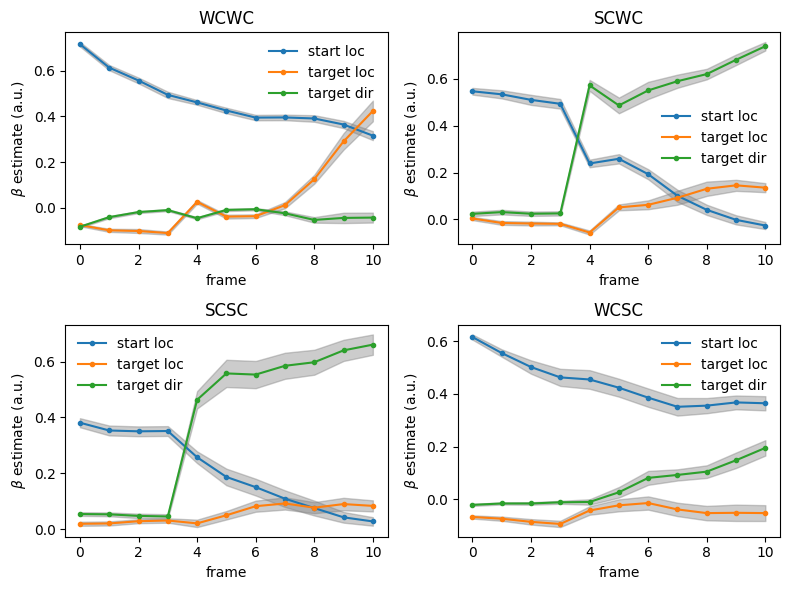

In [324]:
# now perform regressions
from scipy.stats import zscore 
regr = LinearRegression()
conditions = ["WCWC","SCWC","SCSC","WCSC"]
model_names = ["start loc", "target loc", "target dir"]
df1, data_test = make_testset_from_conditions(random_seed=123,input_type=cond[:2],output_type=cond[2:],sorting_mode=1,sortby=None)
df1.reset_index(inplace=True,drop=True)
df1.sort_values("start_loc_id",inplace=True)
model_rdms = []
model_rdms.append(squareform(pdist(df1[["start_loc_label_x","start_loc_label_y"]])))
model_rdms.append(squareform(pdist(df1[["target_loc_label_x","target_loc_label_y"]])))
model_rdms.append(squareform(pdist(df1[["target_dir_label_x","target_dir_label_y"]])))
model_rdms = [rdm/np.max(rdm) for rdm in model_rdms]
design_matrix = np.asarray([zscore(rdm[np.tril_indices(24,k=-1)].flatten()) for rdm in model_rdms]).T
betas = {}
for cond in conditions:
    betas[cond] = np.empty((20,11,len(model_names)))
    for ir in range(20):
        for it in range(11):
            yrdm = testset_results[cond]["rdms_startloc"][ir,it,:,:]
            yrdm = zscore(yrdm[np.tril_indices(24,k=-1)].flatten()).reshape(-1,1)
            
            regr.fit(design_matrix,yrdm)
            betas[cond][ir,it,:] = regr.coef_.flatten()


f, axs = plt.subplots(2,2,figsize=(8,6))
axs = axs.flatten()
sem = lambda x,dim: np.std(x,dim)/np.sqrt(x.shape[dim])
for cond, ax in zip(conditions,axs):
    ls = []
    for i in range(len(model_names)):
        v = betas[cond][:,:,i]
        y_mu = v.mean(0)
        y_err = sem(v,0) 
        l = ax.plot(np.arange(len(y_mu)),y_mu,'-',marker='.')
        ls.append(l[0])
        ax.fill_between(np.arange(len(y_mu)), y_mu-y_err,y_mu+y_err,color="grey",alpha=0.4)
    ax.legend(ls, model_names,frameon=False)
    
    ax.set(xlabel="frame",ylabel=r"$\beta$ estimate (a.u.)",title=cond)
plt.tight_layout()

In SC*, start location can still be inferred from the "noise" ports, as they are distributed within the now invisible bounding box. 
Let's try this again, but without any noise ports!

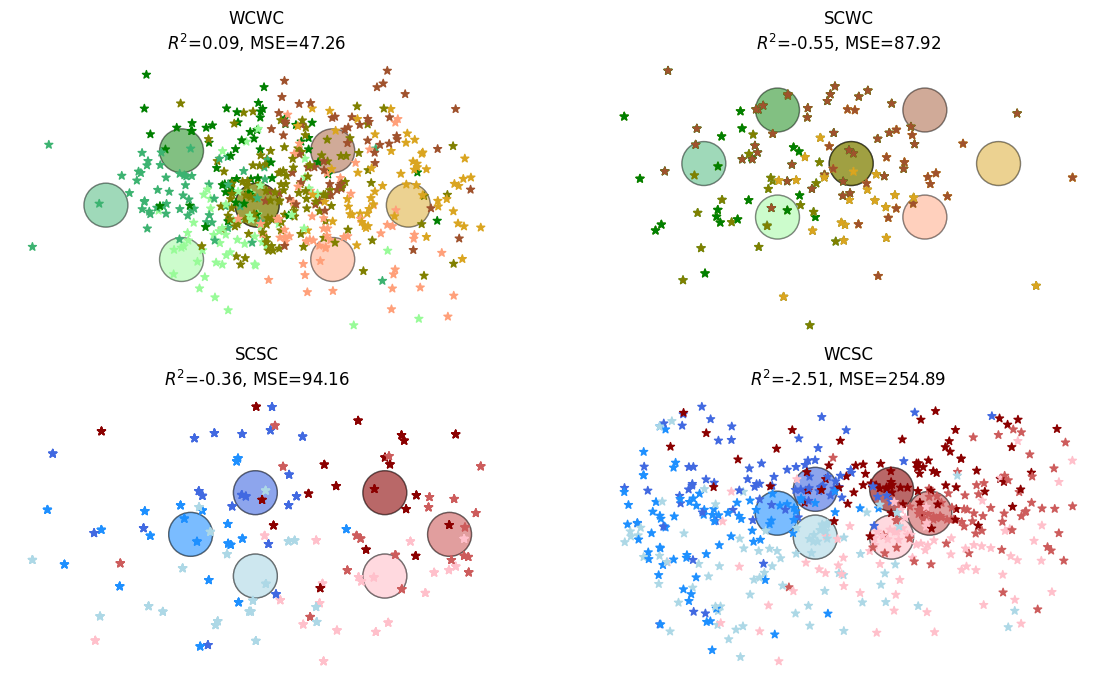

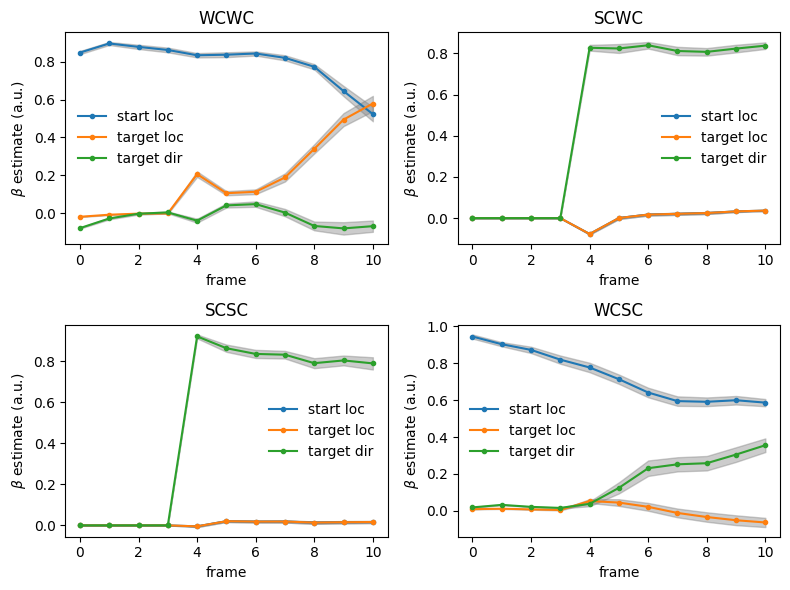

In [342]:
bbox_intensity = 0
noise_intensity = 0


device=torch.device("cuda" if torch.cuda.is_available() else "cpu")


testset_results = {}
for cond in conditions:
    df, data_test = make_testset_from_conditions(random_seed=123,input_type=cond[:2],output_type=cond[2:],sorting_mode=1,sortby=None,bbox_intensity=bbox_intensity, noise_intensity=noise_intensity)
    df.reset_index(inplace=True,drop=True)
    testset_results[cond] = {"predictions": [],
    "ground_truth" : [],
    "hidden_activity" : [],
    "rdms_startloc": [],
    "rdms_targetloc": [],
    "rdms_targetdir": []}
    for run_id in range(n_runs):
        # load model
        with open(f"{results_dir}run_{cond}_{run_id+1}/model.pkl", "rb") as f:
            rnn = pickle.load(f)
        
        predictions = []
        ground_truth = []
        hidden_activity = []
        rnn.to(device)
        for x,y in data_test:
            y_ = rnn.forward(x.reshape(1,11,1600).to(device))
            y_ = y_.to("cpu").detach().numpy()
            predictions.append(y_)
            ground_truth.append(y.to("cpu").detach().numpy())
            hidden_activity.append(rnn.ro.to("cpu").detach().numpy())
        # compute rdms per timepoint:
        rdms_startloc = []
        rdms_targetloc = []
        rdms_targetdir = []

        for t in range(11):
            
            respmat = np.asarray(hidden_activity).squeeze()[df.sort_values(["start_loc_id"],inplace=False).index.to_numpy(),t,:]            
            rdms_startloc.append(squareform(pdist(respmat,metric="correlation")))

            respmat = np.asarray(hidden_activity).squeeze()[df.sort_values(["target_loc_id"],inplace=False).index.to_numpy(),t,:]            
            rdms_targetloc.append(squareform(pdist(respmat,metric="correlation")))

            respmat = np.asarray(hidden_activity).squeeze()[df.sort_values(["target_direction_id"],inplace=False).index.to_numpy(),t,:]            
            rdms_targetdir.append(squareform(pdist(respmat,metric="correlation")))

        testset_results[cond]["ground_truth"].append(np.asarray(ground_truth))
        testset_results[cond]["predictions"].append(np.asarray(predictions).squeeze())
        testset_results[cond]["hidden_activity"].append(np.asarray(hidden_activity).squeeze())
        testset_results[cond]["rdms_startloc"].append(np.asarray(rdms_startloc))
        testset_results[cond]["rdms_targetloc"].append(np.asarray(rdms_targetloc))
        testset_results[cond]["rdms_targetdir"].append(np.asarray(rdms_targetdir))

        
    for k, v in testset_results[cond].items():
        testset_results[cond][k] = np.asarray(v)

# test set performance
f, axs = plt.subplots(2,2,figsize=(14,8))
axs = axs.flatten()
labels = ["target_loc_color","target_loc_color","target_direction_color","target_direction_color"]

for ax,cond,label in zip(axs,conditions,labels):
    
    target_colors = df[label]
    coords_gt = testset_results[cond]["ground_truth"][0,:,[1,0]]
    ax.scatter(*coords_gt,s=1000,marker='o',c=target_colors.to_numpy(),edgecolor='k',alpha=0.2)
    for run_id in range(n_runs):    
        coords_pred = testset_results[cond]["predictions"][run_id,:,[1,0]]
        ax.scatter(*coords_pred,marker="*",c=target_colors.to_numpy())

    r2 = r2_score(testset_results[cond]["ground_truth"].reshape(n_runs*24,2),testset_results[cond]["predictions"].reshape(n_runs*24,2),multioutput="uniform_average")
    mse = mean_squared_error(testset_results[cond]["ground_truth"].reshape(n_runs*24,2),testset_results[cond]["predictions"].reshape(n_runs*24,2),multioutput="uniform_average")
    ax.set_axis_off()
    ax.set_title(cond+"\n"+r"$R^2$="+f"{r2:.2f}, MSE={mse:.2f}")


    # now perform regressions
from scipy.stats import zscore 

regr = LinearRegression()
conditions = ["WCWC","SCWC","SCSC","WCSC"]
model_names = ["start loc", "target loc", "target dir"]
df1, data_test = make_testset_from_conditions(random_seed=123,input_type=cond[:2],output_type=cond[2:],sorting_mode=1,sortby=None)
df1.reset_index(inplace=True,drop=True)
df1.sort_values("start_loc_id",inplace=True)
model_rdms = []
model_rdms.append(squareform(pdist(df1[["start_loc_label_x","start_loc_label_y"]])))
model_rdms.append(squareform(pdist(df1[["target_loc_label_x","target_loc_label_y"]])))
model_rdms.append(squareform(pdist(df1[["target_dir_label_x","target_dir_label_y"]])))
model_rdms = [rdm/np.max(rdm) for rdm in model_rdms]
design_matrix = np.asarray([zscore(rdm[np.tril_indices(24,k=-1)].flatten()) for rdm in model_rdms]).T
betas = {}
for cond in conditions:
    betas[cond] = np.empty((20,11,len(model_names)))
    for ir in range(20):
        for it in range(0,11):
            yrdm = testset_results[cond]["rdms_startloc"][ir,it,:,:]
            yrdm = zscore(yrdm[np.tril_indices(24,k=-1)].flatten(),nan_policy="omit").reshape(-1,1)
            if np.any(np.isnan(yrdm)):
                continue    
            regr.fit(design_matrix,yrdm)
            betas[cond][ir,it,:] = regr.coef_.flatten()


f, axs = plt.subplots(2,2,figsize=(8,6))
axs = axs.flatten()
sem = lambda x,dim: np.std(x,dim)/np.sqrt(x.shape[dim])
for cond, ax in zip(conditions,axs):
    ls = []
    for i in range(len(model_names)):
        v = betas[cond][:,:,i]
        y_mu = v.mean(0)
        y_err = sem(v,0) 
        l = ax.plot(np.arange(len(y_mu)),y_mu,'-',marker='.')
        ls.append(l[0])
        ax.fill_between(np.arange(len(y_mu)), y_mu-y_err,y_mu+y_err,color="grey",alpha=0.4)
    ax.legend(ls, model_names,frameon=False)
    
    ax.set(xlabel="frame",ylabel=r"$\beta$ estimate (a.u.)",title=cond)
plt.tight_layout()
    

C:\Users\Timo\AppData\Local\Temp\ipykernel_14400\996132813.py:8: RuntimeWarning: invalid value encountered in divide
  rdm /= np.max(rdm)
c:\Users\Timo\anaconda3\envs\pytorch_cuda\lib\site-packages\seaborn\matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
c:\Users\Timo\anaconda3\envs\pytorch_cuda\lib\site-packages\seaborn\matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


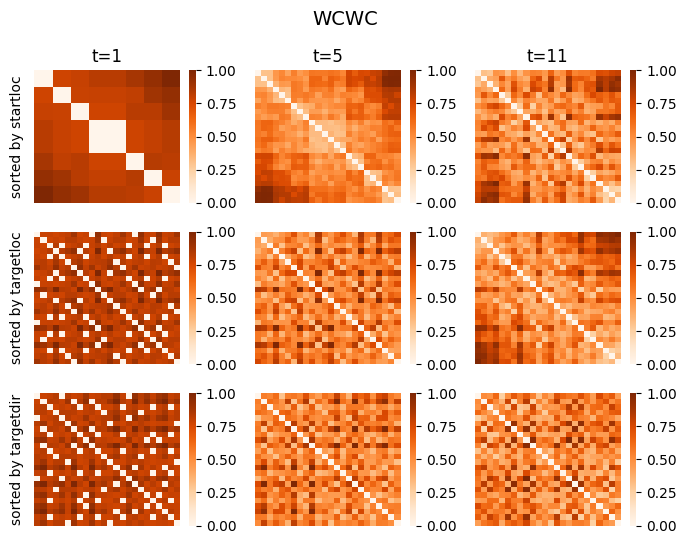

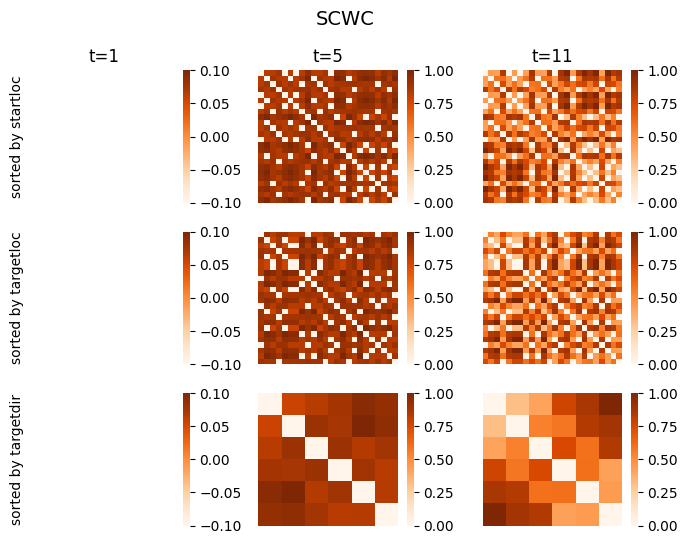

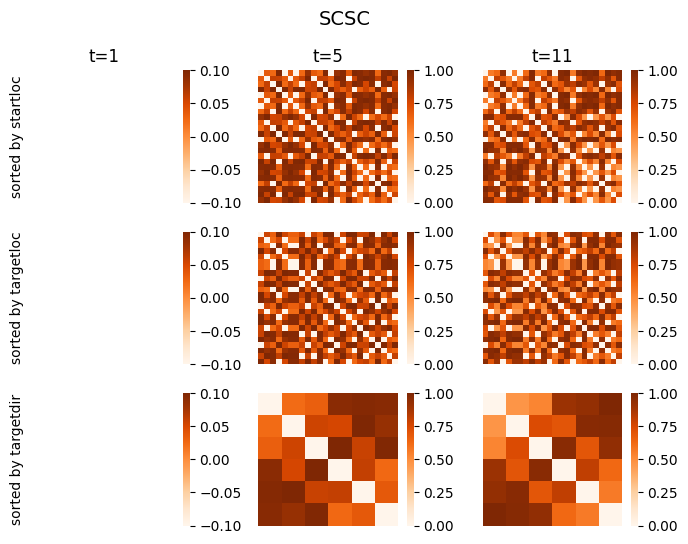

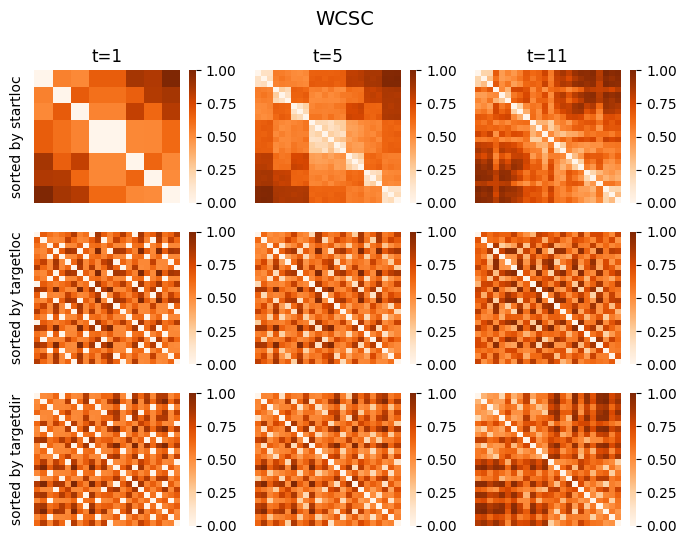

In [338]:
# for each condition, show 3x3 grid (sortedby x t=1, t=5, t=11)
ts = [0,4,10]
for cond in testset_results.keys():
    f,axs = plt.subplots(3,3,figsize=(7,5.5))
    for i,s in enumerate([k for k in testset_results[cond].keys() if "rdms" in k]):
        for j,t in enumerate(ts):            
            rdm = testset_results[cond][s].mean(0)[t,:,:]
            rdm /= np.max(rdm)
            show_cbar =True# True if j==2 else False
            sns.heatmap(rdm,cbar=show_cbar,xticklabels=False,yticklabels=False,cmap="Oranges",ax=axs[i, j])
            if i==0:
                axs[i,j].set_title(f"t={t+1}")
            if j==0:
                axs[i,j].set_ylabel(f"sorted by {s.split('_')[1]}")
            # axs[i,j].set_box_aspect(1)
            # axs[i,j].set_aspect('equal',"box")
    plt.suptitle(cond,fontsize=14)
    plt.tight_layout()